<a href="https://colab.research.google.com/github/nasiksami/FYP2-Codes/blob/main/XceptionNet(93%25).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Nov 30 08:05:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [67]:
import numpy as np
import itertools
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from numpy.random import seed
seed(1337)
import tensorflow
tensorflow.random.set_seed(1337)
import tensorflow as tf

from tensorflow.python.keras.applications import vgg19
from tensorflow.python.keras.applications.vgg19 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras import layers, models, Model, optimizers

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


Text(0.5, 1.0, 'Number of training images per category:')

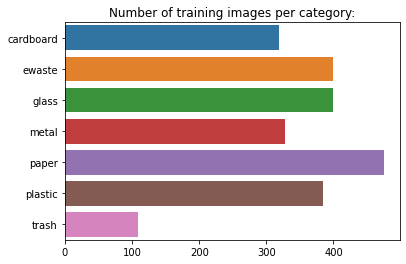

In [4]:
train_data_dir = "/content/drive/MyDrive/dataset_resized/training"

test_data_dir = "/content/drive/MyDrive/dataset_resized/testing"
category_names = sorted(os.listdir('/content/drive/MyDrive/dataset_resized/training'))
nb_categories = len(category_names)
img_pr_cat = []
for category in category_names:
    folder = '/content/drive/MyDrive/dataset_resized/training' + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))
sns.barplot(y=category_names, x=img_pr_cat).set_title("Number of training images per category:")

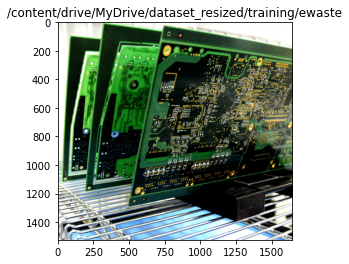

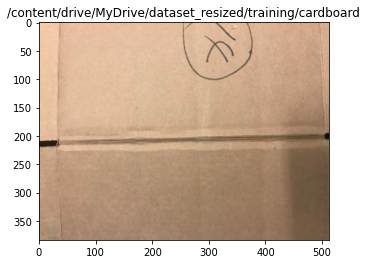

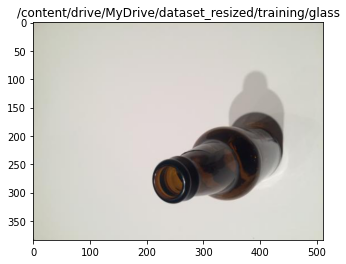

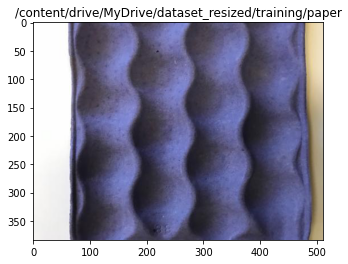

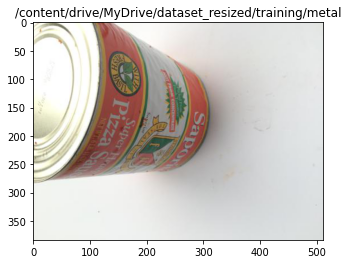

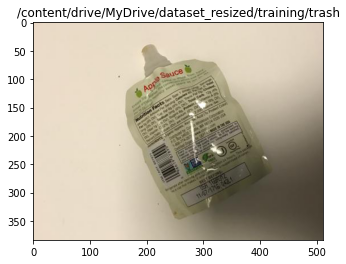

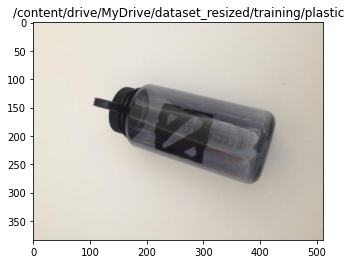

In [5]:
for subdir, dirs, files in os.walk('/content/drive/MyDrive/dataset_resized/training'):
    for file in files:
        img_file = subdir + '/' + file
        image = load_img(img_file)
        plt.figure()
        plt.title(subdir)
        plt.imshow(image)
        break

In [6]:
img_height, img_width = 224,224
conv_base = tf.keras.applications.Xception(weights='imagenet', include_top=False, pooling='max', input_shape = (img_width, img_height, 3),classes=1000,
    classifier_activation="softmax",)


83689472/83683744 [==============================] - 1s 0us/step


In [7]:
for layer in conv_base.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f6566d22a90> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f65295537b8> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f652954d780> True
<tensorflow.python.keras.layers.core.Activation object at 0x7f652954d358> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6529530128> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f65200d6748> True
<tensorflow.python.keras.layers.core.Activation object at 0x7f65200d6b00> True
<tensorflow.python.keras.layers.convolutional.SeparableConv2D object at 0x7f65200789b0> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f6520093e10> True
<tensorflow.python.keras.layers.core.Activation object at 0x7f65200960b8> True
<tensorflow.python.keras.layers.convolutional.SeparableConv2D object at 0x7f65200969e8> True
<tensorflow.python.keras.l

In [8]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Dense(nb_categories, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
dense (Dense)                (None, 7)                 14343     
Total params: 20,875,823
Trainable params: 20,821,295
Non-trainable params: 54,528
_________________________________________________________________


In [9]:
#Number of images to load at each iteration
batch_size = 64
# only rescaling
train_datagen =  ImageDataGenerator(
    rescale=1./255
)
test_datagen =  ImageDataGenerator(
    rescale=1./255
)
# these are generators for train/test data that will read pictures #found in the defined subfolders of 'data/'
print('Total number of images for "training":')
train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size, 
class_mode = "categorical")

print('Total number of images for "testing":')
test_generator = test_datagen.flow_from_directory(
test_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size,
class_mode = "categorical",
shuffle=False)

Total number of images for "training":
Found 2411 images belonging to 7 classes.
Total number of images for "testing":
Found 608 images belonging to 7 classes.


In [10]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [11]:
learning_rate = 5e-5
epochs = 50
earlystopping = EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'max' , 
                              patience = 10,
                              verbose = 1)
checkpoint = ModelCheckpoint("sign_classifier.h5", monitor = 'val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=learning_rate, clipnorm = 1.), metrics = ['acc'])


In [12]:
conv_base =tf.keras.applications.Xception(weights='imagenet', include_top=False, pooling='max', input_shape = (img_width, img_height, 3))

#for layer in conv_base.layers[:-13]:
#layer.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.Dense(nb_categories, activation='softmax'))

In [14]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False,
        brightness_range = (0.9,1.1),
        fill_mode='nearest'
        )

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data

train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size, 
#save_to_dir='augm_images', 
save_prefix='aug', 
save_format='jpg',
class_mode = "categorical")

Found 2411 images belonging to 7 classes.


In [15]:
callbacks = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')

In [16]:
import numpy as np
from datetime import datetime
import time
#from sklearn import tree
#from sklearn.preprocessing import normalize, scale
from sklearn.metrics import accuracy_score
fmt = '%H:%M:%S'
def get_current_time():
    time.ctime()
    return time.strftime(fmt)
first = get_current_time()

In [17]:
learning_rate = 5e-5
epochs = 300
checkpoint = ModelCheckpoint("sign_classifier_augm.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=learning_rate, clipnorm=1.), metrics = ['acc'])
history = model.fit_generator(train_generator, 
                              epochs=epochs, 
                              shuffle=True, 
                              validation_data=test_generator,
                              callbacks=[checkpoint]
                              )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/300
38/38 [==============================] - ETA: 0s - loss: 1.3287 - acc: 0.5504 
Epoch 00001: val_acc improved from -inf to 0.68914, saving model to sign_classifier_augm.h5
38/38 [==============================] - 609s 16s/step - loss: 1.3287 - acc: 0.5504 - val_loss: 1.0118 - val_acc: 0.6891
Epoch 2/300
38/38 [==============================] - ETA: 0s - loss: 0.4100 - acc: 0.8635
Epoch 00002: val_acc improved from 0.68914 to 0.80592, saving model to sign_classifier_augm.h5
38/38 [==============================] - 69s 2s/step - loss: 0.4100 - acc: 0.8635 - val_loss: 0.6133 - val_acc: 0.8059
Epoch 3/300
38/38 [==============================] - ETA: 0s - loss: 0.2029 - acc: 0.9403
Epoch 00003: val_acc improved from 0.80592 to 0.85033, saving model to sign_classifier_augm.h5
38/38 [==============================] - 70s 2s/step - loss: 0.2029 - acc: 0.9403 - val_loss: 0.4825 - val_acc: 0.8503
Epoch 4/300


In [23]:
second = get_current_time()
print("Time taken to train(sec):", datetime.strptime(second, fmt) - datetime.strptime(first, fmt))

Time taken to train(sec): 6:00:05


In [22]:
score=model.evaluate(test_generator,batch_size=8)

10/10 [==============================] - 5s 542ms/step - loss: 0.4820 - acc: 0.9293


In [19]:
score

[0.4819582402706146, 0.9292762875556946]

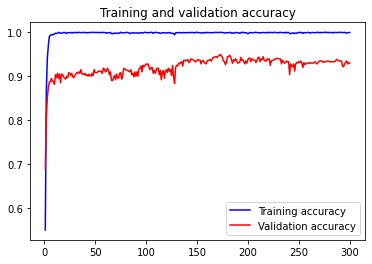

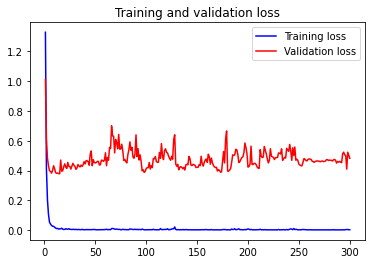

In [24]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)
plt.figure()
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('Accuracy.jpg')
plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('Loss.jpg')

In [40]:
y_pred = model.predict(test_generator)
import numpy as np
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 4, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [43]:
accuracy = accuracy_score(test_generator.classes, y_pred)
print("Accuracy in test set: %0.1f%% " % (accuracy * 100))

Accuracy in test set: 92.9% 


In [48]:

test_generator.reset()
score = model.evaluate_generator(test_generator, (test_generator.samples + (64-1)) //64)
print("For testing data set; Loss: ",score[0]," Accuracy: ", score[1])

For testing data set; Loss:  0.4819582402706146  Accuracy:  0.9292762875556946


In [49]:

train_generator.reset()
score = model.evaluate_generator(train_generator, (train_generator.samples + (64-1)) // 64)

In [50]:

test_generator.reset()
testStep = (test_generator.samples + (64-1)) //64
print("testStep: ", testStep)
predictions = model.predict_generator(test_generator, steps = testStep ,  verbose = 1)
len(predictions)

testStep:  10
10/10 [==============================] - 6s 609ms/step


608

In [51]:
len(predictions)

608

In [52]:

predicted_class_indices=np.argmax(predictions,axis=1)
print(predicted_class_indices)
len(predicted_class_indices)

[0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 0 0 0 4 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 3 2 2 3 2
 2 2 2 2 2 2 2 2 3 3 2 2 2 2 2 2 2 2 2 2 2 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1
 3 5 3 3 3 3 3 3 3 3 3 3 3 3 3 6 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 6 4 4 4 4 4 4 4 4 5 4 4 4 4 4 4 0
 4 4 5 5 5 5 4 5 5 5 5 5 

608

In [53]:

labels = (test_generator.class_indices)
print(labels)

{'cardboard': 0, 'ewaste': 1, 'glass': 2, 'metal': 3, 'paper': 4, 'plastic': 5, 'trash': 6}


In [54]:
labels = dict((v,k) for k,v in labels.items())
print(labels)

{0: 'cardboard', 1: 'ewaste', 2: 'glass', 3: 'metal', 4: 'paper', 5: 'plastic', 6: 'trash'}


In [55]:
predictedLables= [labels[k] for k in predicted_class_indices]
print(predictedLables)
len(predictedLables)

['cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'paper', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'ewaste', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'paper', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'paper', 'paper', 'cardboard', 'cardboard', 'cardboard', 'paper', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboa

608

In [56]:

actualLables= [labels[k] for k in test_generator.classes]
print(actualLables)
len(actualLables)

['cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard'

608

In [57]:
accuracy_score(actualLables, predictedLables)

0.9292763157894737

In [58]:

matrix = confusion_matrix(actualLables, predictedLables)
print(labels)
matrix

{0: 'cardboard', 1: 'ewaste', 2: 'glass', 3: 'metal', 4: 'paper', 5: 'plastic', 6: 'trash'}


array([[ 74,   1,   0,   0,   6,   0,   0],
       [  0, 100,   0,   0,   0,   0,   0],
       [  0,   0,  93,   7,   1,   0,   0],
       [  0,   1,   1,  78,   0,   1,   1],
       [  2,   0,   0,   1, 112,   2,   2],
       [  0,   1,   4,   3,   4,  84,   1],
       [  0,   0,   0,   2,   1,   1,  24]])

In [59]:
print(classification_report(actualLables, predictedLables))

              precision    recall  f1-score   support

   cardboard       0.97      0.91      0.94        81
      ewaste       0.97      1.00      0.99       100
       glass       0.95      0.92      0.93       101
       metal       0.86      0.95      0.90        82
       paper       0.90      0.94      0.92       119
     plastic       0.95      0.87      0.91        97
       trash       0.86      0.86      0.86        28

    accuracy                           0.93       608
   macro avg       0.92      0.92      0.92       608
weighted avg       0.93      0.93      0.93       608



In [69]:

recall_score( actualLables, predictedLables,average='weighted')

0.9292763157894737

In [70]:
precision_score( actualLables, predictedLables,average='weighted')

0.9311895276534273

In [64]:

selectedClasses = [ 'cardboard','ewaste', 'glass', 'metal','paper', 'plastic', 'trash']

In [65]:

#Prepared code that is taken from SKLearn Website, Creates Confusion Matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 74   1   0   0   6   0   0]
 [  0 100   0   0   0   0   0]
 [  0   0  93   7   1   0   0]
 [  0   1   1  78   0   1   1]
 [  2   0   0   1 112   2   2]
 [  0   1   4   3   4  84   1]
 [  0   0   0   2   1   1  24]]


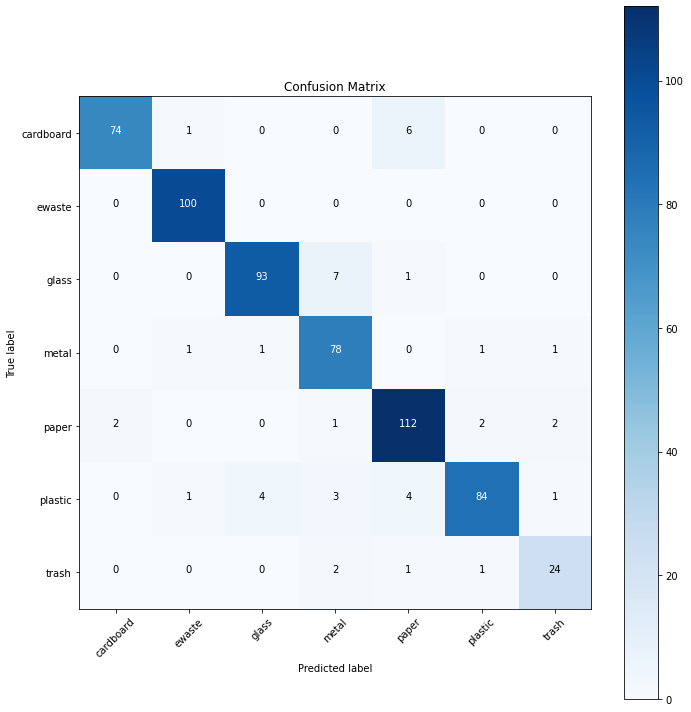

In [68]:

plt.figure(figsize=(10,10))
cm_plot_labels = selectedClasses
plot_confusion_matrix(matrix,cm_plot_labels, normalize=False
                      , title = 'Confusion Matrix')

In [73]:
from tensorflow.keras.models import load_model

model.save('/content/drive/MyDrive/Xception(93%).h5')